<a href="https://colab.research.google.com/github/stephanie0620/113_1/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90/week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用 yfinance 抓取股價資料

In [5]:
import yfinance as yf
import pandas as pd

def get_stock_data(stock_id, start_date, end_date):
    '''
    使用 yfinance 抓取股價資料

    參數：
    - stock_id (str): 股票代號
    - start_date (str): 開始日期 (YYYY-MM-DD)
    - end_date (str): 結束日期 (YYYY-MM-DD)

    返回：
    - df (DataFrame): 包含股價資料的 DataFrame
    '''
    df = yf.download(stock_id, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.columns = ['開盤價', '最高價', '最低價', '收盤價', '成交量']
    return df


In [6]:
# 抓取台積電 2024 年的股價
df_org = get_stock_data('2330.TW', '2024-01-01', '2024-09-30')
df_org.head()

[*********************100%***********************]  1 of 1 completed


,開盤價,最高價,最低價,收盤價,成交量
Date,,,,,
2024-01-02,590.0,593.0,589.0,593.0,26059058
2024-01-03,584.0,585.0,576.0,578.0,37106763
2024-01-04,580.0,581.0,577.0,580.0,15309129
2024-01-05,578.0,580.0,574.0,576.0,18158971
2024-01-08,582.0,585.0,579.0,583.0,17761275


In [7]:
df = df_org.copy()
df.columns

Index(['開盤價', '最高價', '最低價', '收盤價', '成交量'], dtype='object')

## ARIMA模型

In [8]:
from sklearn.model_selection import train_test_split

# 選擇收盤價作為預測目標
close_prices = df['收盤價']

train_data, test_data = train_test_split(close_prices, test_size=0.3, shuffle=False)

print(f"訓練集長度: {len(train_data)}")
print(f"測試集長度: {len(test_data)}")

訓練集長度: 125
測試集長度: 54


In [19]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 忽略警告訊息
warnings.filterwarnings("ignore")

# 定義網格搜尋函數來優化 ARIMA 參數，使用 RMSE 作為評估標準
def optimize_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # 定義 ARIMA 模型
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()

                    # 使用模型進行自回歸預測 (insample)
                    predictions = model_fit.predict(start=0, end=len(train)-1)

                    # 計算 RMSE
                    rmse = mean_squared_error(train, predictions, squared=False)

                    # 如果 RMSE 更低，則更新最佳模型參數
                    if rmse < best_score:
                        best_score, best_cfg = rmse, (p, d, q)
                        print(f'ARIMA{(p, d, q)} RMSE={rmse:.4f}')
                except:
                    continue
    print(f'最佳 ARIMA 參數: {best_cfg}，RMSE={best_score:.4f}')
    return best_cfg

ARIMA(0, 0, 0) RMSE=118.9466
ARIMA(0, 0, 1) RMSE=66.1962
ARIMA(0, 0, 2) RMSE=44.8179
ARIMA(0, 0, 3) RMSE=39.5328
ARIMA(0, 0, 4) RMSE=35.4450
ARIMA(0, 0, 5) RMSE=32.9611
ARIMA(1, 0, 0) RMSE=22.8096
ARIMA(1, 0, 1) RMSE=22.7688
ARIMA(1, 0, 2) RMSE=22.6796
ARIMA(1, 0, 3) RMSE=22.6425
ARIMA(1, 0, 4) RMSE=22.6326
ARIMA(1, 0, 5) RMSE=22.6268
ARIMA(2, 0, 4) RMSE=22.6170
ARIMA(2, 0, 5) RMSE=22.6070
ARIMA(3, 0, 2) RMSE=22.4690
ARIMA(3, 0, 5) RMSE=22.4321
ARIMA(4, 0, 3) RMSE=22.3021
ARIMA(5, 0, 5) RMSE=22.2514
最佳 ARIMA 參數: (5, 0, 5)，RMSE=22.2514


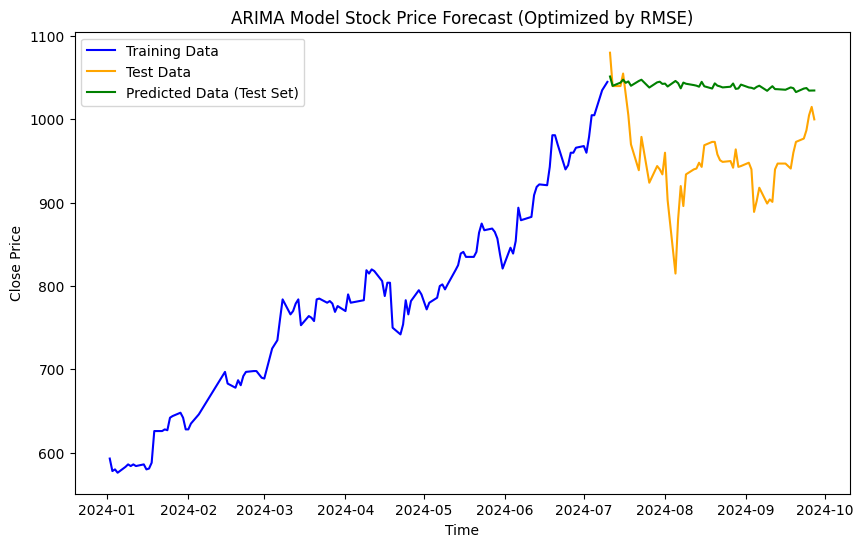

In [21]:
# 設定 p, d, q 的取值範圍
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# 呼叫函數進行網格搜尋，找到最佳的 ARIMA 模型參數
best_order = optimize_arima(train_data, p_values, d_values, q_values)

# 使用最佳參數進行最終預測
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()

# 進行未來預測（基於測試集的長度）
predictions = model_fit.forecast(steps=len(test_data))

# 可視化結果
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, predictions, label='Predicted Data (Test Set)', color='green')
plt.title('ARIMA Model Stock Price Forecast (Optimized by RMSE)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## 均值回歸策略

In [25]:
df_mean = df_org.copy()
df_mean.head()

,開盤價,最高價,最低價,收盤價,成交量
Date,,,,,
2024-01-02,590.0,593.0,589.0,593.0,26059058
2024-01-03,584.0,585.0,576.0,578.0,37106763
2024-01-04,580.0,581.0,577.0,580.0,15309129
2024-01-05,578.0,580.0,574.0,576.0,18158971
2024-01-08,582.0,585.0,579.0,583.0,17761275


In [23]:
# 設計均值回歸策略
import numpy as np
def mean_reversion_strategy(data, short_window, long_window):
    # 計算短期和長期移動平均線，基於 '收盤價'
    data['Short_MA'] = data['收盤價'].rolling(window=short_window).mean()
    data['Long_MA'] = data['收盤價'].rolling(window=long_window).mean()

    # 建立買入和賣出訊號，當短均線大於長均線時設為 1，否則設為 0
    data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)

    # 將買入或賣出訊號轉換為持倉變化（Position），1 表示買入，-1 表示賣出
    data['Position'] = data['Signal'].diff().fillna(0)

    return data


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 回測策略並可視化結果
def backtest_and_plot(data):
    # 資產淨值初始化
    initial_capital = 100000

    # 建立 positions DataFrame，預設填入 0.0
    positions = pd.DataFrame(index=data.index).fillna(0.0)

    # 根據 Signal 計算每次交易 100 股
    positions['Stock'] = data['Signal'] * 100

    # 使用 '收盤價' 進行價值計算
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Holdings'] = positions['Stock'] * data['收盤價']

    # 計算持倉變化
    pos_diff = positions.diff()

    # 現金計算：從初始資本中扣除每次買賣的價值
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * data['收盤價']).cumsum()

    # 總資產 = 現金 + 持倉股票價值
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 設定 Seaborn 風格
    sns.set(style="whitegrid")

    # 建立子圖，將股票價格和總資產分別放置
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    # 第一張圖 - 股票價格及其均線
    ax1.plot(data['收盤價'], label='Stock Price', color='blue', linewidth=2)
    ax1.plot(data['Short_MA'], label='Short Moving Average', color='green', linestyle='--')
    ax1.plot(data['Long_MA'], label='Long Moving Average', color='red', linestyle='--')

    # 標記買賣點
    ax1.plot(data[data['Position'] == 1].index,
             data['收盤價'][data['Position'] == 1],
             '^', markersize=10, color='g', label='Buy Signal', lw=0)

    ax1.plot(data[data['Position'] == -1].index,
             data['收盤價'][data['Position'] == -1],
             'v', markersize=10, color='r', label='Sell Signal', lw=0)

    ax1.set_title('Stock Price and Trading Signals')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')

    # 第二張圖 - 總資產值變化
    ax2.plot(portfolio['Total'], label='Portfolio Value', color='purple', linewidth=2)
    ax2.fill_between(portfolio.index, portfolio['Total'], color='purple', alpha=0.1)
    ax2.set_title('Portfolio Value Over Time')
    ax2.set_ylabel('Portfolio Value')
    ax2.set_xlabel('Date')
    ax2.legend(loc='best')

    # 繪製圖表
    plt.tight_layout()
    plt.show()

    # 額外的資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple', linewidth=2)
    plt.fill_between(portfolio.index, portfolio['Total'], color='purple', alpha=0.1)
    plt.title('Detailed Portfolio Value Over Time')
    plt.ylabel('Portfolio Value')
    plt.xlabel('Date')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


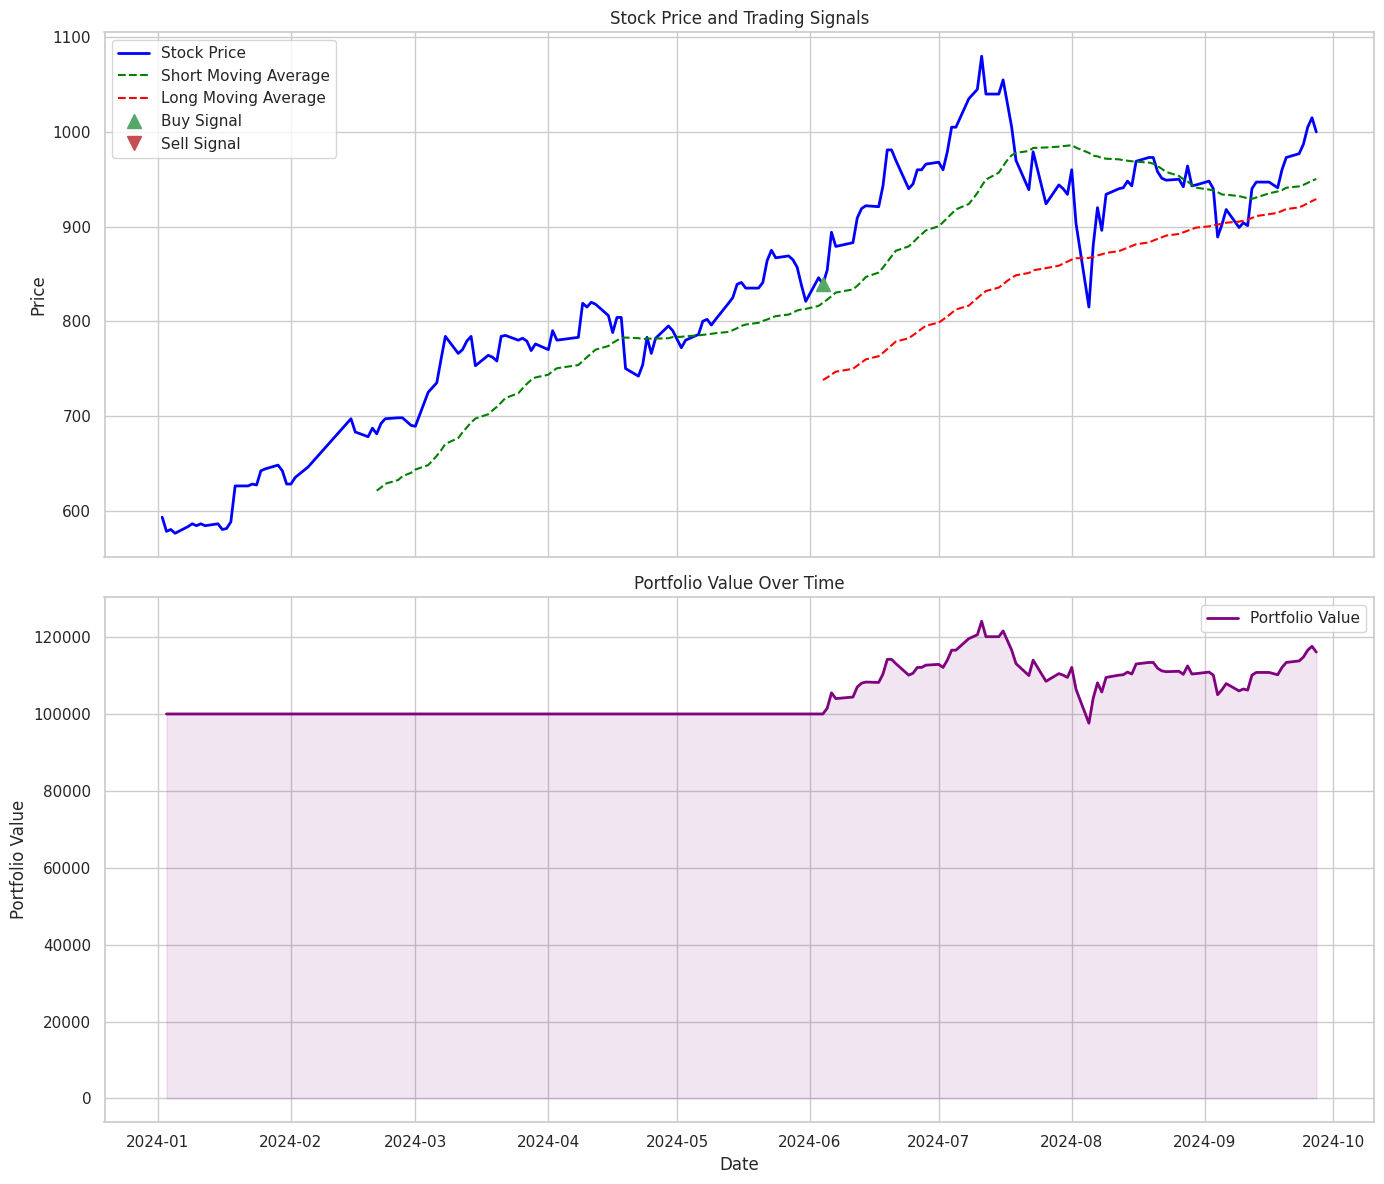

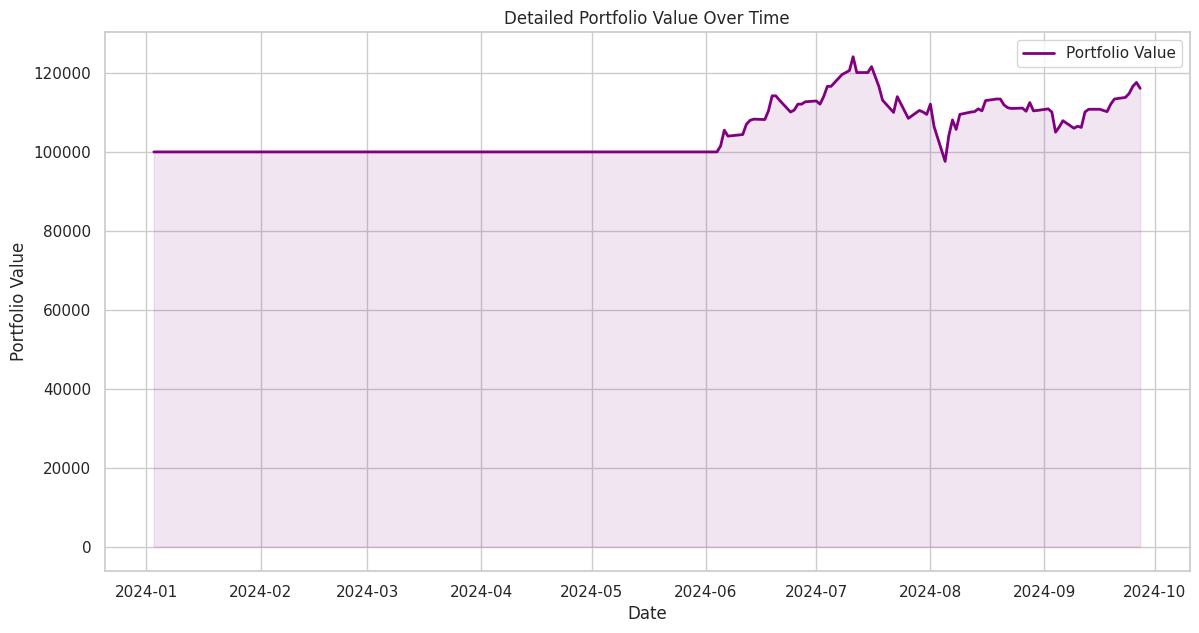

In [28]:
#短期移動平均線窗口與長期移動平均線窗口
short_window = 30
long_window = 100

#應用均值回歸策略
df_mean = mean_reversion_strategy(df_mean, short_window, long_window)

#回測並可視化結果
backtest_and_plot(df_mean)